# Control of platform angle and wheel velocity with gravity

Do all imports:

In [1]:
import numpy as np
import sympy as sym
from scipy import linalg
import matplotlib.pyplot as plt
import ae353_platform

pybullet build time: Dec 10 2021 09:55:58


Suppress the use of scientific notation when printing small numbers:

In [2]:
np.set_printoptions(suppress=True)

Create an instance of the simulator (do `Kernel -> Restart` before evaluating this cell).

In [3]:
simulator = ae353_platform.Simulator(
    display=False,
    roll=(np.pi / 2),
    tau_max=1.
)

The equations of motion are

$$
\begin{aligned}
J_1 \ddot{q}_1 &= \tau - m_wgl\sin(q_1) \\
J_2 \dot{v}_2 &= - \left( \dfrac{J_1 + J_2}{J_1} \right) \tau + \left( \dfrac{J_2}{J_1} \right) m_wgl\sin(q_1)
\end{aligned}
$$

where

* $q_1$ is the platform angle
* $\dot{q}_1$ is the platform velocity
* $v_2$ is the wheel velocity
* $\tau$ is the torque applied *to* the platform *by* the wheel

and

$$
J_1 = J_p + m_wl^2
\qquad
\qquad
J_2 = J_w
$$

where parameters are as follows:

In [4]:
# distance from platform axis to wheel axis
l = 1.

# radius of wheel
rw = 0.5

# mass of wheel
mw = 0.25

# moi of wheel
Jw = 0.5 * mw * rw**2

# mass of platform
mp = 12. * (1. - mw * l**2) / (3.**2 + 2.**2)

# moment of inertia of platform
Jp = (1. / 12.) * mp * (3.**2 + 2.**2)

# gravity
g = 9.81

# composite parameters
J1 = Jp + mw * l**2
J2 = Jw

Define helper functions for analysis.

In [5]:
# Define a function to return a state-space model for a given
# choice of equilibrium point. Also return the function f that
# defines the original nonlinear ODEs (in numeric form).
def get_model(q1e, v1e, v2e, taue):
    # Define variables
    q1, v1, v2, tau = sym.symbols('q1, v1, v2, tau')
    
    # Define right-hand side of ODEs
    f = sym.Matrix([
        v1,
        (1 / J1) * (tau - mw * g * l * sym.sin(q1)),
        (1 / J2) * (- ((J1 + J2) / J1) * tau + (J2 / J1) * mw * g * l * sym.sin(q1))
    ])

    # Convert floating-point to rational numbers
    f = sym.nsimplify(f, rational=True)
    
    # Verify equilibrium point
    f_num = sym.lambdify([q1, v1, v2, tau], f)
    if not np.allclose(f_num(q1e, v1e, v2e, taue), 0.):
        raise Exception('equilibrium point is invalid')
    
    # Find A and B in symbolic form
    A_sym = f.jacobian([q1, v1, v2])
    B_sym = f.jacobian([tau])

    # Create lambda functions to allow numerical evaluation of A and B
    A_num = sym.lambdify([q1, v1, v2, tau], A_sym)
    B_num = sym.lambdify([q1, v1, v2, tau], B_sym)

    # Find A and B in numeric form (making sure the result is floating-point)
    A = A_num(q1e, v1e, v2e, taue).astype(float)
    B = B_num(q1e, v1e, v2e, taue).astype(float)

    # Return A, B, and f (both symbolic and numeric)
    return A, B, f, f_num

# Define a controller that implements linear state feedback.
class Controller:
    def __init__(self, K, q1e, v1e, v2e, taue):
        self.K = K
        self.q1e = q1e
        self.v1e = v1e
        self.v2e = v2e
        self.taue = taue
    
    def reset(self):
        pass
    
    def run(
            self,
            t,
            platform_angle,
            platform_velocity,
            wheel_angle,
            wheel_velocity,
        ):
        
        # Find state
        x = np.array([
            platform_angle - self.q1e,
            platform_velocity - self.v1e,
            wheel_velocity - self.v2e,
        ])
        
        # Find input
        u = - self.K @ x
        
        # Find actuator command
        tau = u[0]
        
        wheel_torque = -tau
        return wheel_torque
    
# Define a function to get data from simulation for a given choice
# of equilibrium point, gain matrix, and initial condition.
def get_data_from_simulation(simulator, q1e, v1e, v2e, taue, K, q1i, v1i, v2i, max_time=5.0):
    # Create controller
    controller = Controller(K, q1e, v1e, v2e, taue)
    
    # Reset simulator
    simulator.reset(
        platform_angle=q1i,
        platform_velocity=v1i,
        wheel_angle=0.,
        wheel_velocity=v2i,
    )

    # Reset controller
    controller.reset()

    # Run simulator
    data = simulator.run(
        controller,
        max_time=max_time,
    )
    
    # Return data
    return data

# Define a function to find numeric solution to closed-loop (linear) system.
def get_data_from_model(data, q1e, v1e, v2e, A, B):
    # Define initial conditions
    x0 = np.array([
        data['platform_angle'][0] - q1e,
        data['platform_velocity'][0] - v1e,
        data['wheel_velocity'][0] - v2e,
    ])

    # Get time
    t = data['t']
    
    # Create empty array to hold state at each time
    x = np.empty((len(t), 3))
    u = np.empty((len(t), 1))

    # Compute state at each time
    for i in range(len(t)):
        x[i] = linalg.expm((A - B @ K) * t[i]) @ x0
        u[i] = - K @ x[i]
    
    # Return state and input at each time
    return x, u

## Make a plot to verify linearization

Choose equilibrium point.

In [6]:
(q1e, v1e, v2e, taue) = (np.pi, 0., 0., 0.)

Linearize equations of motion about equilibrium point.

In [7]:
A, B, f_sym, f_num = get_model(q1e, v1e, v2e, taue)

Show $A$ and $B$:

In [8]:
print(f'A =\n{A}\n\nB =\n{B}')

A =
[[ 0.      1.      0.    ]
 [ 2.4525  0.      0.    ]
 [-2.4525  0.      0.    ]]

B =
[[  0.]
 [  1.]
 [-33.]]


The state-space model

$$\dot{x} = Ax + Bu$$

should approximate the original (nonlinear) model

$$\dot{m} = f(m, n)$$

near the equilibrium point $m_e, n_e$. In particular, it should be true that

$$Ax+Bu \approx f(x + m_e, u + n_e)$$

for $x \approx 0$ and $u \approx 0$, or equivalently that

$$A(m - m_e)+B(n - n_e) \approx f(m, n)$$

for $m \approx m_e$ and $n \approx n_e$. One way to check that this is true is by plotting both functions near the equilibrium point. We will do so as $q_1$ varies from $q_{1e} - \pi$ to $q_{1e} + \pi$ while keeping $v_1=v_{1e}$ and $v_2=v_{2e}$, as an example.

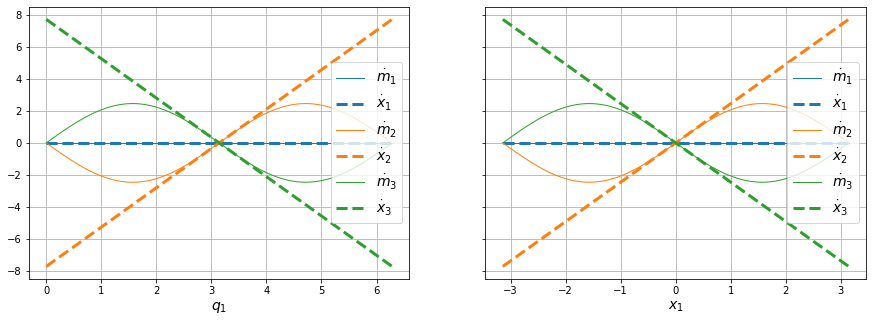

In [9]:
# Create a figure with two subplots side-by-side that share a y-axis
fig, (ax_m, ax_x) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# Create an array of values for q1
q1 = np.linspace(q1e - np.pi, q1e + np.pi, 100)

# Create empty arrays to hold xdot (i.e., Ax+Bu) and mdot (i.e., f(m,n))
xdot = np.empty((len(q1), 3))
mdot = np.empty((len(q1), 3))

# Iterate over all elements of q1
for i in range(len(q1)):
    
    # Compute Ax+Bu
    x = np.array([q1[i] - q1e, 0. - v1e, 0. - v2e])
    u = np.array([0. - taue])
    xdot[i] = A @ x + B @ u
    
    # Compute f(m,n)
    mdot[i] = f_num(q1[i], 0., 0., 0.).flatten()

# Plot as a function of q1
ax_m.plot(q1, mdot[:, 0], '-', label='$\dot{m}_1$', color='C0', linewidth=1)
ax_m.plot(q1, xdot[:, 0], '--', label='$\dot{x}_1$', color='C0', linewidth=3)
ax_m.plot(q1, mdot[:, 1], '-', label='$\dot{m}_2$', color='C1', linewidth=1)
ax_m.plot(q1, xdot[:, 1], '--', label='$\dot{x}_2$', color='C1', linewidth=3)
ax_m.plot(q1, mdot[:, 2], '-', label='$\dot{m}_3$', color='C2', linewidth=1)
ax_m.plot(q1, xdot[:, 2], '--', label='$\dot{x}_3$', color='C2', linewidth=3)
ax_m.legend(fontsize=14)
ax_m.set_xlabel('$q_1$', fontsize=14)
ax_m.grid()

# Plot as a function of x1
ax_x.plot(q1 - q1e, mdot[:, 0], '-', label='$\dot{m}_1$', color='C0', linewidth=1)
ax_x.plot(q1 - q1e, xdot[:, 0], '--', label='$\dot{x}_1$', color='C0', linewidth=3)
ax_x.plot(q1 - q1e, mdot[:, 1], '-', label='$\dot{m}_2$', color='C1', linewidth=1)
ax_x.plot(q1 - q1e, xdot[:, 1], '--', label='$\dot{x}_2$', color='C1', linewidth=3)
ax_x.plot(q1 - q1e, mdot[:, 2], '-', label='$\dot{m}_3$', color='C2', linewidth=1)
ax_x.plot(q1 - q1e, xdot[:, 2], '--', label='$\dot{x}_3$', color='C2', linewidth=3)
ax_x.legend(fontsize=14)
ax_x.set_xlabel('$x_1$', fontsize=14)
ax_x.grid()

## Make a plot to compare simulation results with what the state-space model predicts

Choose gain matrix for controller.

In [10]:
K = np.array([[35., 25., 0.5]])

Verify that gain matrix results in a stable closed-loop system.

In [11]:
s = linalg.eigvals(A - B @ K)
for i in range(len(s)):
    print(f's{i + 1} = {s[i]:.2f}')

s1 = -3.24+2.99j
s2 = -3.24-2.99j
s3 = -2.01+0.00j


Choose initial conditions.

In [18]:
(q1i, v1i, v2i) = (np.pi + 0.1, 0., 0.)

Get and parse simulation results.

In [19]:
data = get_data_from_simulation(simulator, q1e, v1e, v2e, taue, K, q1i, v1i, v2i, max_time=5.0)
t = data['t']
q1 = data['platform_angle']
v1 = data['platform_velocity']
v2 = data['wheel_velocity']
tau = -data['wheel_torque']

Get $x(t)$ and $u(t)$ from state-space model.

In [20]:
x, u = get_data_from_model(data, q1e, v1e, v2e, A, B)

Plot results.

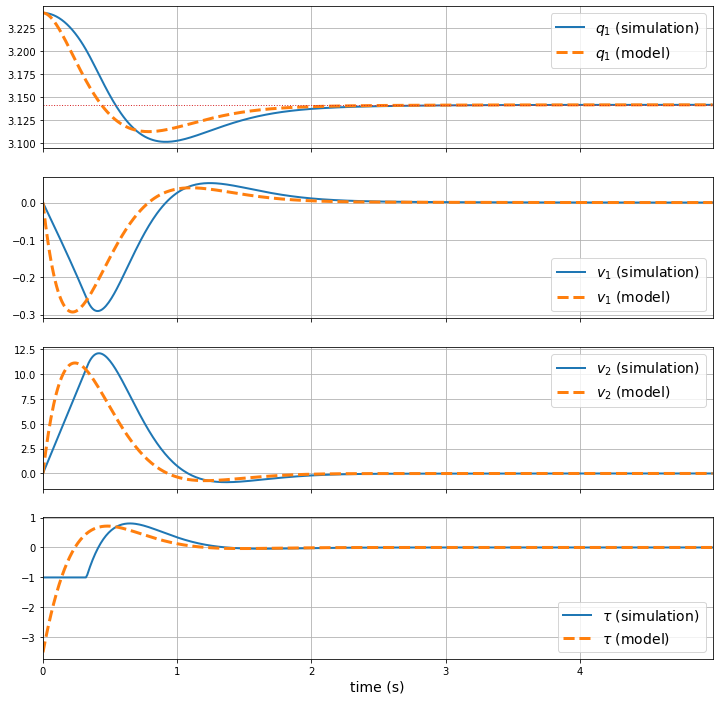

In [21]:
fig, (ax_q1, ax_v1, ax_v2, ax_tau) = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

ax_q1.plot(t, q1, '-', label='$q_1$ (simulation)', linewidth=2)
ax_q1.plot(t, x[:, 0] + q1e, '--', label='$q_1$ (model)', linewidth=3)
ax_q1.plot(t, np.pi * np.ones_like(t), ':', linewidth=1, color='C3')
ax_q1.legend(fontsize=14)
ax_q1.grid()

ax_v1.plot(t, v1, '-', label='$v_1$ (simulation)', linewidth=2)
ax_v1.plot(t, x[:, 1] + v1e, '--', label='$v_1$ (model)', linewidth=3)
ax_v1.legend(fontsize=14)
ax_v1.grid()

ax_v2.plot(t, v2, '-', label='$v_2$ (simulation)', linewidth=2)
ax_v2.plot(t, x[:, 2] + v2e, '--', label='$v_2$ (model)', linewidth=3)
ax_v2.legend(fontsize=14)
ax_v2.grid()

ax_tau.plot(t, tau, '-', label=r'$\tau$ (simulation)', linewidth=2)
ax_tau.plot(t, u[:, 0] + taue, '--', label=r'$\tau$ (model)', linewidth=3)
ax_tau.legend(fontsize=14)
ax_tau.set_xlabel('time (s)', fontsize=14)
ax_tau.set_xlim(t[0], t[-1])
ax_tau.grid()

## Make a plot to visualize the impact of varying initial conditions

Compute $q_1(5)$ as $q_1(0)$ varies from $q_{1e} - 0.4$ to $q_{1e} + 0.4$.

In [16]:
# Define array of initial conditions
q1i = np.linspace(q1e - 0.4, q1e + 0.4, 50)

# Define empty array to hold final conditions
q1f = np.empty_like(q1i)

# Iterate over all initial conditions
for i in range(len(q1i)):
    data = get_data_from_simulation(simulator, q1e, v1e, v2e, taue, K, q1i[i], v1i, v2i, max_time=5.0)
    q1f[i] = data['platform_angle'][-1]

Plot results.

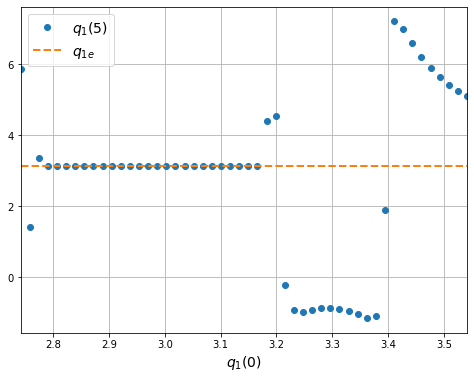

In [17]:
fig, (ax) = plt.subplots(1, 1, figsize=(8, 6), sharex=True)

ax.plot(q1i, q1f, '.', markersize=12, label='$q_1(5)$')
ax.plot(q1i, q1e * np.ones_like(q1i), '--', linewidth=2, label='$q_{1e}$')
ax.set_xlim(q1i[0], q1i[-1])
ax.set_xlabel('$q_1(0)$', fontsize=14)
ax.legend(fontsize=14)
ax.grid()